In [283]:
# CS 598 APK Fall 2017 Project
# Written by: Yong Escobar
# Shape optimization with equality constraints using first order gradient descent
# References:
# [KeHh]: "Numerical Solution of Elliptic Shape Optimization Problems using Wavelet Based BEM" by K. Eppler and H. Harbrecht.

import math
import scipy.integrate as integrate
import scipy.sparse.linalg as ssla
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as npla

# computes a set of boundary points in x,y coordinates given Fourier coefficients and number of nodes on boundary
# Example: boundary_points[3,0] returns the x coordinate of the 4th boundary point
def des_boundary_points(a, n) :
    boundary_points = np.empty([n,2])
    
    for i in range(n) :
        angle = 2 * math.pi * (i/n)
        boundary_points[i] = radius(a, angle) * np.array([math.cos(angle), math.sin(angle)])
        
    return boundary_points

# computes the normal vector at a boundary point parameterized by the angle
def boundary_normal(a, angle) :
    n = len(a)
    N = int((n-1)/2)
    result_x = -a[0] * math.cos(angle)
    result_y = -a[0] * math.sin(angle)
    
    for i in range(1, N + 1) :
        result_x += a[i]*(-i**2 * math.cos(i*angle)*math.cos(angle) + 2*i*math.sin(i*angle)*math.sin(angle) - math.cos(i*angle)*math.cos(angle)) \
                    + a[n-i]*(-i**2*math.sin(i*angle)*math.cos(angle) - 2*i*math.cos(i*angle)*math.sin(angle) - math.sin(i*angle)*math.cos(angle))
                            
        result_y += a[i]*(-i**2 * math.cos(i*angle)*math.sin(angle) - 2*i*math.sin(i*angle)*math.cos(angle) - math.cos(i*angle)*math.sin(angle)) \
                    + a[n-i]*(-i**2*math.sin(i*angle)*math.sin(angle) + 2*i*math.cos(i*angle)*math.cos(angle) - math.sin(i*angle)*math.sin(angle))
        
    magnitude = npla.norm([result_x, result_y])
    norm_vector = -1/magnitude * np.array([result_x, result_y])
        
    return norm_vector 

In [284]:
# radius of a point generated by Fourier coefficients a at angle phi
# Page 112, r(\phi) definition of [KeHh]
def radius(a, phi) :
    n = len(a)
    N = int((n-1)/2)
    result = a[0]
    
    for i in range(1, N + 1) :
        result += a[i]*math.cos(i * phi) + a[n-i] * math.sin(i * phi)
        
    return result

# point on a boundary (parameterized by fourier cofficients) parametrized by the angle
# Page 107, definition of boundary [KeHh]
def surface_point(a, angle) :
    result = radius(a, angle) * np.array([math.cos(angle), math.sin(angle)])
    return result

# volume of the shape generated by Fourier coefficients a
# Page 108, V(\Omega)
def volume(a) :
    result, err = integrate.quad(lambda x: (1/2)*radius(a, x)**2, 0, 2*math.pi)
    return result

# gradient of volume
# Page 109, Equation 6 [KeHh]
def grad_volume(a) :
    n = len(a)
    N = int((n-1)/2)
    
    result = np.empty(n)
    result[0], err = integrate.quad(lambda x: radius(a,x), 0, 2 * math.pi)
    
    for i in range(1,N+1) :
        result[i], err = integrate.quad(lambda x: math.sin(i*x) * radius(a,x), 0, 2 * math.pi)
        result[n-i], err = integrate.quad(lambda x: math.cos(i*x) * radius(a,x), 0, 2 * math.pi)
        
    return result

# bending rigidity of the shape generated by Fourier coefficients a
# Page 108, Equation 2 [KeHh]
def bend(a) :
    result, err = integrate.quad(lambda x: (1/4)*math.sin(x)**2 * radius(a,x)**4, 0, 2 * math.pi)
    return result

# gradient of bending rigidity
# Page 109, Equation 2 [KeHh]
def grad_bend(a) :
    
    n = len(a)
    N = int((n-1)/2)
    
    result = np.empty(n)
    result[0], err = integrate.quad(lambda x: math.sin(x)**2 * radius(a,x)**3, 0, 2 * math.pi)
    
    for i in range(1,N+1) :
        result[i], err = integrate.quad(lambda x: math.sin(i*x) * math.sin(x)**2 * radius(a,x)**3, 0, 2 * math.pi)
        result[n-i], err = integrate.quad(lambda x: math.cos(i*x) * math.sin(x)**2 * radius(a,x)**3, 0, 2 * math.pi)
        
    return result

# Sovles for du/dn in page 114, equation 13
def solve_dun(a, n) :
   
    dp = 2 * math.pi / n
    points = des_boundary_points(a, n)
    # array of normal vectors for each nodes on the boundary
    normal = np.array([boundary_normal(a, dp*i) for i in range(n)])
    
    # v(x) = -(1/2)(x^2 + y^2) is a Newton potential used to convert PDE u(x) into a Laplace equation
    # dvn := dv/dn
    dvn = np.empty(n)
    for i in range(n) :
        dvn[i] = np.dot(-points[i,:], normal[i])
    # A is a n x n matrix := I/2 + D where D is double layer potential
    A = np.empty([n,n])
    
    for i in range(n) :
        source = points[i, :]
        for j in range (n) :
            if i == j :
                A[i,j] = 1/2
            else :
                A[i,j], err = integrate.quad(lambda angle: 
                                        np.dot(boundary_normal(a, angle), source - surface_point(a, angle)) 
                                             * radius(a, angle) /npla.norm(source - surface_point(a,angle))**2,
                                        2*math.pi*(j/n) - math.pi/n, 2*math.pi*(j/n) + math.pi/n)


    # b = -v given where w = -v on the boundary
    b = np.array([1/2 * npla.norm(points[i,:]) for i in range(points.shape[0])])
    
    # Solve for sigma: A sigma = b
    sigma, _ = ssla.gmres(A, b)

    # "Integral Equations: Theory and Numerical Treatment" by Wolfgang Hackbusch, Page 299
    # dw/dx = -1/(4pi) * integral[(n_y / |x-y|^2 - 2 * <n_y, x-y> * (x - y) / |x - y|^4)*sigma(y)] over boundary segment that has node x
    # dw/dn at x_i = dw/dx * n_{x_i}
    # dw/wx at x_i = ith row of (dD/dn) * sigma
    # ith row of (dD/dn) = ith row of B
    # Example: to get dw/dx at x_5, compute the inner product of the 5th row of B and sigma
    # to get dw/dn at x_5, compute dw/dx * n_x at x_5. 
    B = np.empty([n,n,2])
    
    for i in range(n) :
        source = points[i, :]
        for j in range(n) :
            if i == j :
                B[i,j] = 0
            else :
                B[i,j] = sigma[j] * (boundary_normal(a, dp * j)/npla.norm(source - surface_point(a, dp * j))**2 - 2 * np.dot(boundary_normal(a, dp*j), source - surface_point(a, dp * j)) *(source - surface_point(a, dp*j))/npla.norm(source - surface_point(a, dp*j))**4)
    
    dwx = np.array([np.sum(B[i,:,:] * sigma[:, np.newaxis], axis = 0) for i in range(n)]) 
    dwn = np.empty(n)
    
    for i in range(n) :
        dwn[i] = np.dot(dwx[i,:], normal[i])
        
    dun = dvn + dwn
                 
    return dun


# torsion rigidity of a shape generated by Fourier coefficients a with n points
# Page 108, Equation 3 [KeHh] for analytical formula
# Page 114, Section 4.1 [KeHh] for computational formula
def torsion(a, n) :
    
    points = des_boundary_points(a, n)
    
    #dun is the solution to double layer 
    dun = solve_dun(a, n)
    
    # first integral of Equation 13
    result, err = integrate.quad(lambda x: -(1/8)*radius(a,x)**4, 0, 2 * math.pi)
    
    dp = 2 * math.pi / n 
    
    # second integral of Equation 13
    scalar_multiples = np.array([(1/4) * npla.norm(points[i])**2 for i in range(n)]) * np.array([radius(a, dp * i) for i in range(n)])
    kernel = dun * scalar_multiples
    result -= np.trapz(kernel, x = np.array([dp * i for i in range(n)]))
    result *= 2
    
    return result

def grad_torsion(a, n) :
    
    n = len(a)
    N = int((n-1)/2)
    dp = 2 * math.pi/n

    dun = solve_dun(a, n)

    result = np.empty(n)

    kernel_array = np.array([radius(a, dp*i) * dun[i]**2 for i in range(n)])
    result[0] = np.trapz(kernel_array, x = np.array([dp * i  for i in range(n)]))

    for j in range(1,N+1) :
        kernel_array = np.array([math.sin(j * dp * i) * radius(a, dp*i) * dun[i]**2 for i in range(n)])
        result[j] = np.trapz(kernel_array , x = np.array([dp * i  for i in range(n)]))

        kernel_array = np.array([math.cos(j * dp * i) * radius(a, dp*i) * dun[i]**2 for i in range(n)])
        result[n-j] = np.trapz(kernel_array , x = np.array([dp * i  for i in range(n)]))
    return result

# inner product of lambda_xcm and x_cm
# Page 109, Equation 5 and Page 110, Lambda function [KeHh]
def x_cm(a) :
    result_x, err_x = integrate.quad(lambda x: (1/3)*math.cos(x)*radius(a,x)**3, 0, 2 * math.pi)
    result_y, err_y = integrate.quad(lambda x: (1/3)*math.sin(x)*radius(a,x)**3, 0, 2 * math.pi)
    return np.array([result_x, result_y])

# gradient of inner product of lambda_xcm and x_cm
def grad_x_cm(a, lambda_xcm) :
    n = len(a)
    N = int((n-1)/2)
    
    result = np.empty(n)
    result[0], err = integrate.quad(lambda x: lambda_xcm[0]*math.cos(x)*radius(a,x)**2 + lambda_xcm[1]*math.sin(x)*radius(a,x)**2, 0, 2*math.pi)
     
    for i in range(1,N+1) :
        result[i], err = integrate.quad(lambda x: math.sin(i*x) * (lambda_xcm[0] * math.cos(x) + lambda_xcm[1]*math.sin(x)) * radius(a,x) ** 2, 0, 2 * math.pi)
        result[n-i], err = integrate.quad(lambda x: math.cos(i*x) * (lambda_xcm[0] * math.cos(x) + lambda_xcm[1]*math.sin(x)) * radius(a,x) ** 2, 0, 2 * math.pi)

    return result


In [285]:
# Lagrangian function of the optimization problem
# Page 110, L(\Omega, \Lambda), [KeHh]
def lagrange(a, n, lambda_v, lambda_t, lambda_cm, volume_0, torsion_0, c) :
    result = -bend(a) + lambda_v * (volume(a) - volume_0) + lambda_t * (torsion(a,n) - torsion_0) + np.dot(lambda_cm, x_cm(a))
    return result

# Gradient of Lagrangian function of the optimization problem
def grad_lagrange(a, n, lambda_v, lambda_t, lambda_cm) :
    result = -grad_bend(a) + lambda_v * grad_volume(a) + lambda_t * grad_torsion(a,n) +  grad_x_cm(a, lambda_cm)
    return result
    

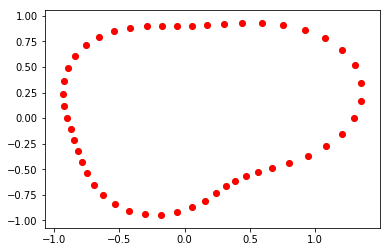

KeyboardInterrupt: 

In [286]:
# Fourier coefficients
a = [1, .1, .1, .1, .1, .1, .1]

# number of nodes on the boundary
n = 50

# initial lambda values for lagrange gradient descent
lambda_v = 1
lambda_t = 1
lambda_cm = np.array([1,1])

# equality constraint
volume_0 = volume(a)
torsion_0 = torsion(a, n)

# [KeHh]: "where c is fixed but appropriately chosen" (no explicit value given)
c = 1/10

# n points from the closed curve generated by Fourier coefficients
points = des_boundary_points(a, n)

# Plotting the points
plt.scatter(x = points[:,0], y = points[:,1], c = "lightgreen")
points = des_boundary_points(a, 50)
plt.scatter(x = points[:,0], y = points[:,1], c = "red")
plt.show()

# k := number of iterations of gradient descent 
for k in range(5) :
    lambda_v = lambda_v + c * (volume_0 - volume(a))
    lambda_cm = lambda_cm + c * x_cm(a)
    lambda_t = lambda_t + c * (torsion_0 - torsion(a,n))
    
    change_direction = grad_lagrange(a, n, lambda_v, lambda_t, lambda_cm)
    
    # if the norm of the gradient of langrange satisfies a threshold, end the iterative method
    if(npla.norm(change_direction) < .0005) :
        break
    else :
        a = a - .05 * change_direction
# Plotting the points
plt.scatter(x = points[:,0], y = points[:,1], c = "lightgreen")
points = des_boundary_points(a, 50)
plt.scatter(x = points[:,0], y = points[:,1], c = "red")
plt.show()